In [1]:
# Import necessary packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import requests
from bs4 import BeautifulSoup
import urllib.request as urllib
import time
import random
import string
from string import digits
import re
from datetime import datetime

In [2]:
# Upload CSV file
from google.colab import files
uploaded = files.upload()

Saving value_fixed.csv to value_fixed.csv


In [3]:
# Read in CSV file
df = pd.read_csv('value_fixed.csv')

# Drop unecessary columns
df = df.drop(["Unnamed: 0"], axis=1)

# Move Market Value column to front of DataFrame
col_name='Market_Value'
market_value = df.pop(col_name)
df.insert(0, col_name, market_value)
df

,Market_Value,ID,Name,Age,Position,Nationality,League,Height,Footedness,Contract_Expiration,Games,Goals,Assists,Yellow_Cards,Red_Cards,19/20 Games,19/20 Goals,19/20 Assists,19/20 Yellow,19/20 2Yellow,19/20 Red,19/20 Minutes,20/21 Games,20/21 Goals,20/21 Assists,20/21 Yellow,20/21 2Yellow,20/21 Red,20/21 Minutes
0,77000000.0,241641,Bernardo Silva,26,Attacking Midfield,Portugal,England First Tier,1.73,left,1538,381,70,67,36,1,34,6,7,5,0,0,2028,23,2,4,4,0,0,1813
1,66000000.0,225693,Fabinho,27,Defensive Midfield,Brazil,England First Tier,1.88,right,807,378,36,30,87,0,28,2,3,6,0,0,2074,23,0,1,5,0,0,1936
2,3300000.0,344015,Ben Woodburn,21,Attacking Midfield,Other,England First Tier,1.74,right,442,99,18,18,7,0,3,0,0,0,0,0,56,20,2,0,2,0,0,1203
3,44000000.0,340950,Diogo Jota,24,Left Winger,Portugal,England First Tier,1.78,right,1538,240,83,41,40,2,34,7,1,4,0,0,2298,14,8,0,2,0,0,820
4,60500000.0,131789,Roberto Firmino,29,Centre0Forward,Brazil,England First Tier,1.81,right,807,475,141,103,43,0,38,9,8,0,0,0,3004,29,6,5,1,0,0,2310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11999,2750000.0,70280,Peniel Mlapa,30,Centre0Forward,Other,Other League,1.93,right,806,366,21,21,50,0,18,11,1,5,0,0,1620,19,10,2,3,0,0,1710
12000,2750000.0,57935,Álvaro Giménez,29,Centre0Forward,Spain,Other League,1.83,left,76,284,10,10,50,2,13,1,0,2,0,0,570,22,3,1,0,0,0,803
12001,2750000.0,22388,Bafétimbi Gomis,35,Centre0Forward,France,Other League,1.84,right,441,679,66,66,42,2,29,27,4,1,0,0,2148,25,18,4,2,0,0,2053
12002,2640000.0,265481,Michael Estrada,24,Centre0Forward,Other,Other League,1.87,right,625,184,28,28,27,1,7,2,0,0,0,0,264,31,9,3,3,0,0,1818


In [4]:
# Replace the following leagues to "Other League" as they had similar Market Value distributions (see box plot below)
df['League'] = df['League'].replace(['Russia First Tier', 'Portugal First Tier', 'Netherlands First Tier', 
                                     'Belgium First Tier', 'Austria First Tier'], 'Other League')

In [5]:
# Combine simialar positions into the same category
# This was decided after viewing the extremely low correlation between individual positions and Market Value
df['Position'] = df['Position'].replace(['Left Winger', 'Right Winger', 'Centre0Forward', 'Second Striker'],'Attack')
df['Position'] = df['Position'].replace(['Central Midfield', 'Attacking Midfield', 'Defensive Midfield', 'Left Midfield', 'Right Midfield'], 'Midfield')
df['Position'] = df['Position'].replace(['Centre0Back', 'Left0Back', 'Right0Back'], 'Defense')

# Data Exploration

In [6]:
# Encode categorical features
one_hot_p = pd.get_dummies(df['Position'])
one_hot_f = pd.get_dummies(df['Footedness'])
one_hot_league = pd.get_dummies(df['League'])
one_hot_nat = pd.get_dummies(df['Nationality'])

In [7]:
# Concatenate DataFrames and drop old categorical columns
df = pd.concat([df, one_hot_p, one_hot_f, one_hot_league, one_hot_nat], axis=1)
df = df.drop(['Footedness', 'Nationality', 'League', 'Position'], axis = 1)

In [8]:
# Correct column names to ensure consistency
df = df.rename(columns={"Contract_Expiration": "Contract Expiration",
                   "Yellow_Cards": "Yellow Cards",
                   "Red_Cards": "Red Cards",
                   "Market_Value": "Market Value",
                  "both": "Both",
                  "right": "Right",
                  "left": "Left"})

In [ ]:
# View data description
df.describe()

,Market Value,ID,Age,Height,Contract Expiration,Games,Goals,Assists,Yellow Cards,Red Cards,19/20 Games,19/20 Goals,19/20 Assists,19/20 Yellow,19/20 2Yellow,19/20 Red,19/20 Minutes,20/21 Games,20/21 Goals,20/21 Assists,20/21 Yellow,20/21 2Yellow,20/21 Red,20/21 Minutes,Attack,Defense,Midfield,Both,Left,Right,Austria First Tier,Belgium First Tier,England First Tier,France First Tier,Germany First Tier,Italy First Tier,Netherlands First Tier,Other League,Portugal First Tier,Russia First Tier,Spain First Tier,Argentina,Belgium,Brazil,England,France,Germany,Italy,Other,Portugal,Spain,Uruguay
count,1.200400e+04,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.0000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000,12004.000000
mean,3.350936e+06,286791.312646,26.136371,1.806649,460.436771,193.605715,25.088304,16.423942,28.074475,1.666028,15.657114,1.819060,1.305648,2.410530,0.070227,0.059897,1101.938271,15.522493,1.542986,1.128457,2.1487,0.061896,0.060730,1022.149117,0.305981,0.364295,0.329723,0.048234,0.258164,0.693602,0.020826,0.033072,0.034822,0.034655,0.036488,0.038487,0.032073,0.676275,0.033989,0.028491,0.030823,0.055232,0.020160,0.063479,0.040237,0.057897,0.047318,0.045985,0.580473,0.022742,0.055482,0.010996
std,8.855201e+06,186044.948344,4.523553,0.065517,430.219374,132.917434,35.658489,20.697662,24.707077,2.122785,10.752596,3.194584,2.072050,2.574086,0.271658,0.250956,884.157005,9.205391,2.688140,1.779055,2.1644,0.250802,0.249089,758.560460,0.460841,0.481252,0.470132,0.214269,0.437643,0.461016,0.142809,0.178833,0.183336,0.182912,0.187508,0.192377,0.176200,0.467916,0.181208,0.166376,0.172845,0.228441,0.140553,0.243832,0.196522,0.233559,0.212326,0.209461,0.493502,0.149087,0.228927,0.104290
min,1.100000e+04,2989.000000,16.000000,1.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.850000e+05,130028.500000,23.000000,1.760000,77.000000,87.000000,4.000000,3.000000,10.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,323.000000,8.000000,0.000000,0.000000,0.0000,0.000000,0.000000,367.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.700000e+05,261498.500000,26.000000,1.810000,441.000000,173.000000,12.000000,9.000000,22.000000,1.000000,15.000000,1.000000,0.000000,2.000000,0.000000,0.000000,914.500000,16.000000,1.000000,0.000000,2.0000,0.000000,0.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.200000e+06,406637.250000,29.000000,1.850000,806.000000,278.000000,32.000000,22.000000,40.000000,2.000000,24.000000,2.000000,2.000000,4.000000,0.000000,0.000000,1760.000000,23.000000,2.000000,2.000000,3.0000,0.000000,0.000000,1581.250000,1.000000,1.000000,1.000000,0.000000,1.0

Average Age: 26.14


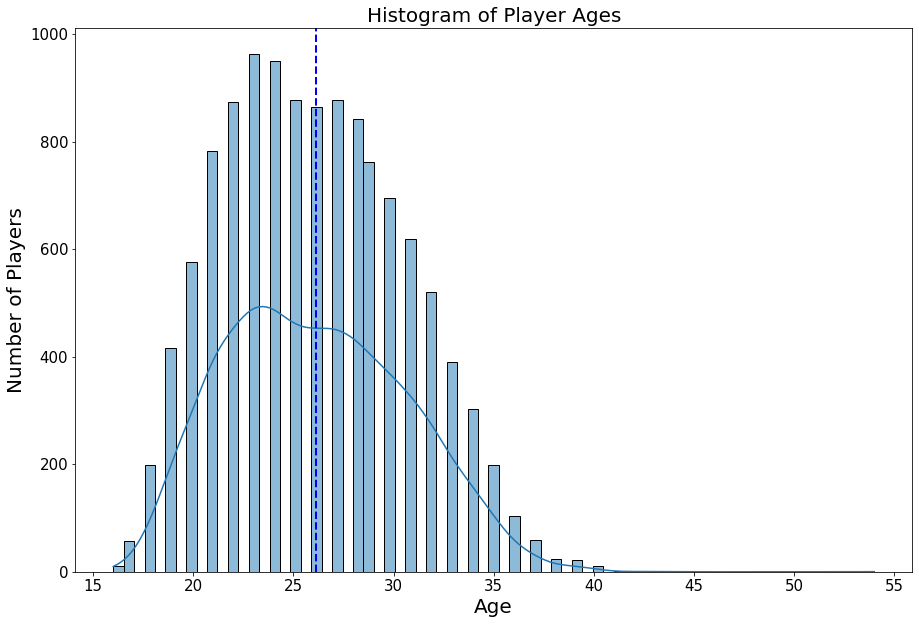

In [ ]:
# Calculate mean age
mean_age = df['Age'].mean()

# Hisplay histogram of ages
plt.figure(figsize=(15,10))
ax = sns.histplot(data=df['Age'], kde=True)
plt.axvline(mean_age, color='b', linestyle='dashed', linewidth=2)
ax.tick_params(labelsize=15)
ax.set_ylabel('Number of Players', fontsize = 20)
ax.set_xlabel('Age', fontsize = 20)
ax.set_title('Histogram of Player Ages', fontsize=20)
#ax.ticklabel_format(useOffset=False, style='plain')
print("Average Age: {:,.2f}".format(mean_age))
plt.show()

In [ ]:
# Remove outliers
df = df[df['Age'] < 41]

Average Age: 26.13


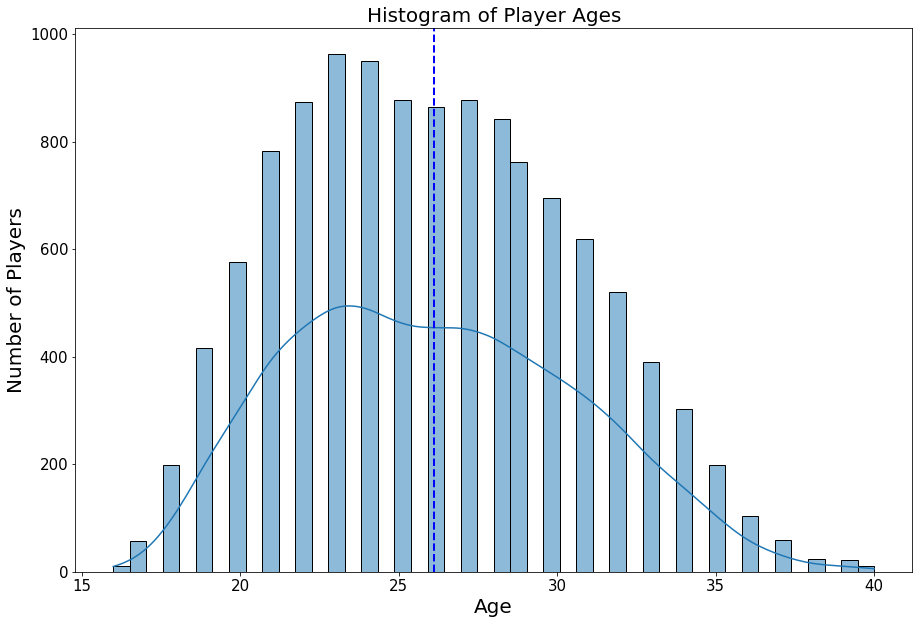

In [ ]:
# Calculate mean age
mean_age = df['Age'].mean()

# Histogram of player ages
plt.figure(figsize=(15,10))
ax = sns.histplot(data=df['Age'], kde=True)
plt.axvline(mean_age, color='b', linestyle='dashed', linewidth=2)
ax.tick_params(labelsize=15)
ax.set_ylabel('Number of Players', fontsize = 20)
ax.set_xlabel('Age', fontsize = 20)
ax.set_title('Histogram of Player Ages', fontsize=20)
#ax.ticklabel_format(useOffset=False, style='plain')
print("Average Age: {:,.2f}".format(mean_age))
plt.show()

In [ ]:
# Calculate and display the standard deviation, mean, and median for Market Value
std_marketval = df['Market Value'].std()
mean_marketval = df['Market Value'].mean()
median_marketval = df['Market Value'].median()
print("Market Value Standard Deviation: ${:,.2f}".format(std_marketval))
print("Market Value Mean: ${:,.2f}".format(mean_marketval))
print("Market Value Median: ${:,.2f}".format(median_marketval))

Market Value Standard Deviation: $8,856,477.04
Market Value Mean: $3,352,023.58
Market Value Median: $770,000.00


Average Market Value: $3,352,023.58


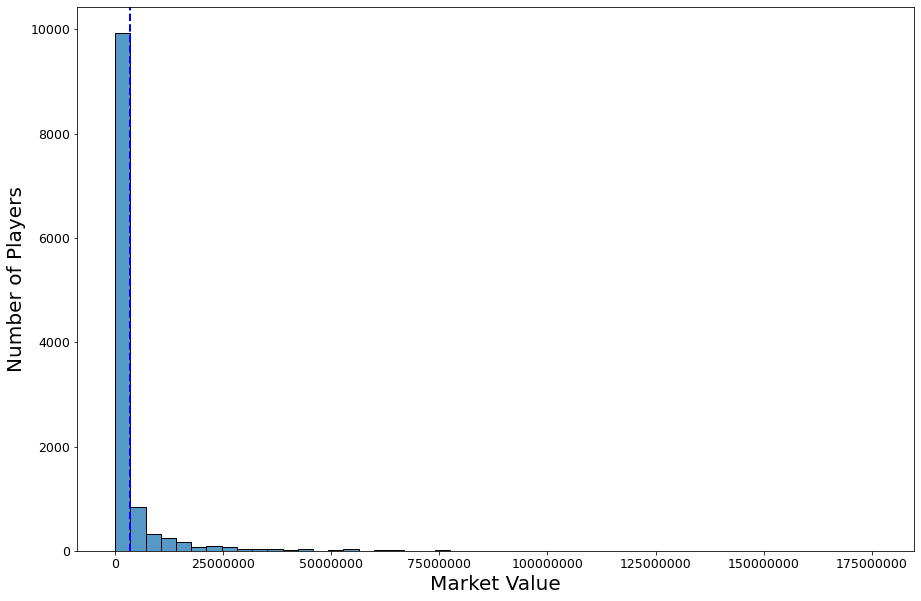

In [ ]:
# Histogram of player Market Values
plt.figure(figsize=(15,10))
ax = sns.histplot(data=df['Market Value'], kde=False, bins=50)
plt.axvline(median_marketval, color='b', linestyle='dashed', linewidth=2)
ax.tick_params(labelsize=12.5)
ax.set_ylabel('Number of Players', fontsize = 20)
ax.set_xlabel('Market Value', fontsize = 20)
ax.set_title('Histogram of Player Market Values', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain')
print("Median Market Value: ${:,.2f}".format(median_marketval))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Median market value: $770,000.00


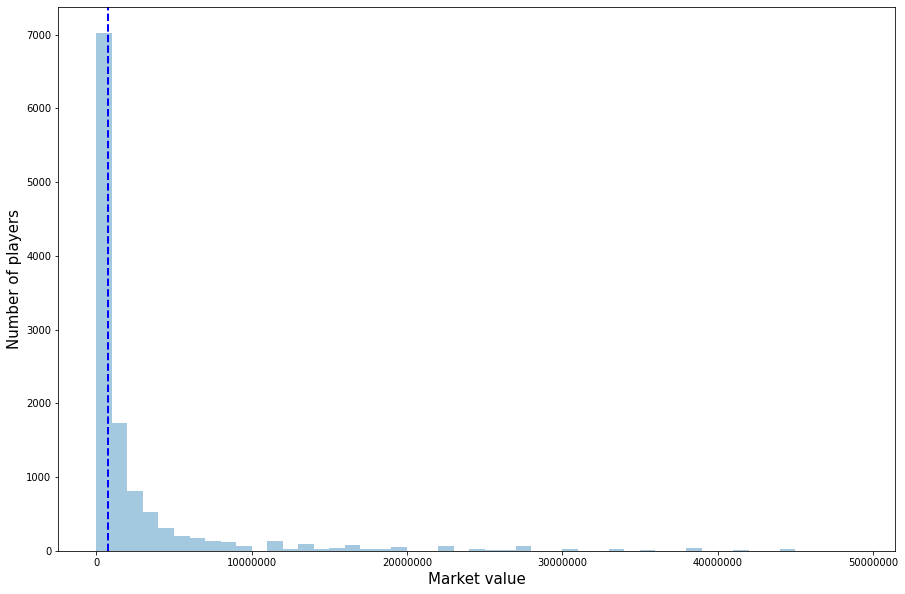

In [ ]:
# Histogram to review distribution of median market values
plt.figure(figsize=(15,10))
ax = sns.distplot(df['Market Value'], kde=False, bins = np.arange(0,50000000,1000000))
ax.tick_params(labelsize=10)
ax.set_ylabel('Number of players', fontsize = 15)
ax.set_xlabel('Market value', fontsize = 15)
ax.ticklabel_format(useOffset=False, style='plain')
plt.axvline(median_marketval, color='b', linestyle='dashed', linewidth=2)
print("Median market value: ${:,.2f}".format(median_marketval))

In [ ]:
# Create unencoded DataFrame to use for categorical data visualizations
df_unencoded = pd.read_csv('values_fixed.csv')
df_unencoded = df_unencoded.drop(["Unnamed: 0"], axis=1)
df_unencoded['League'] = df_unencoded['League'].replace(['Russia First Tier', 'Portugal First Tier',
                                                         'Netherlands First Tier','Belgium First Tier',
                                                         'Austria First Tier'], 'Other League')
col_name='Market_Value'
market_value = df_unencoded.pop(col_name)
df_unencoded.insert(0, col_name, market_value)
df_unencoded = df_unencoded.rename(columns={"Contract_Expiration": "Contract Expiration",
                   "Yellow_Cards": "Yellow Cards",
                   "Red_Cards": "Red Cards",
                  "both": "Both",
                  "right": "Right",
                  "left": "Left"})
df_unencoded = df_unencoded[df_unencoded['Age'] < 41]

NameError: ignored

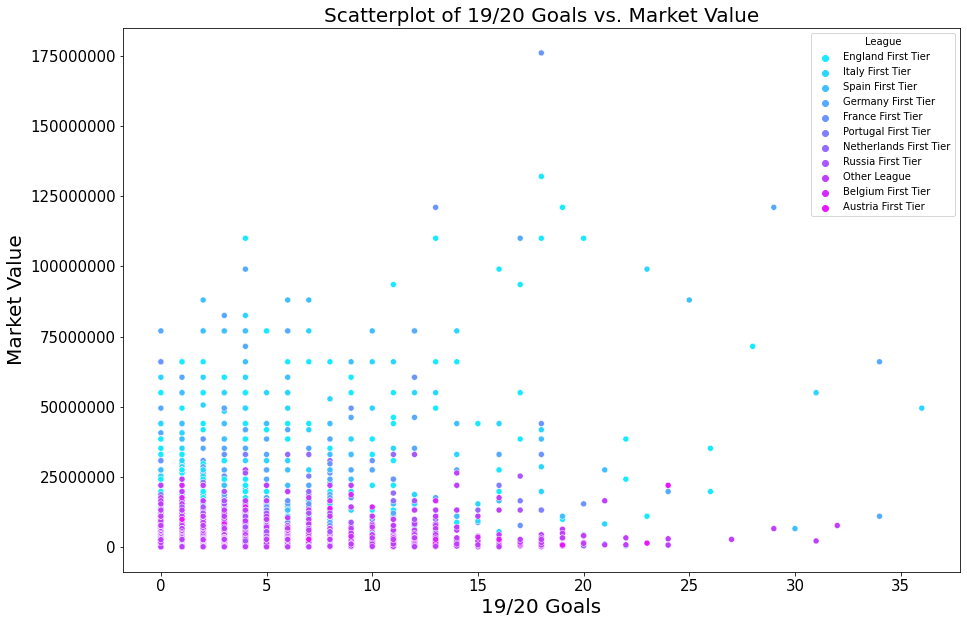

In [ ]:
# Scatterplot of 19/20 Goals vs. Market Value
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df_unencoded, x='19/20 Goals', y='Market_Value', hue='League', palette='cool', legend=True)
ax.tick_params(labelsize=15)
ax.set_ylabel('Market Value', fontsize = 20)
ax.set_xlabel('19/20 Goals', fontsize = 20)
ax.set_title('Scatterplot of 19/20 Goals vs. Market Value', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

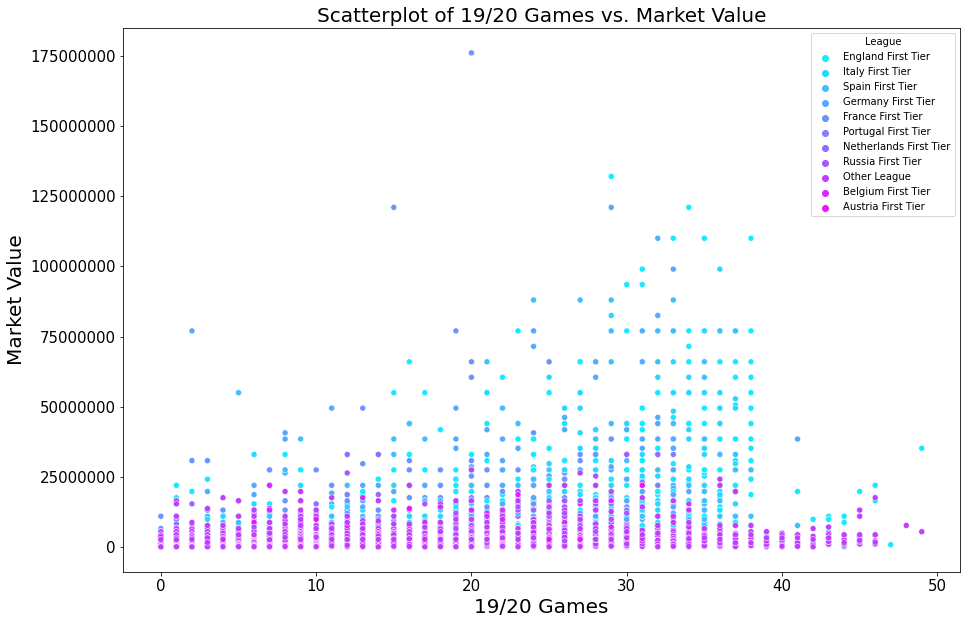

In [ ]:
# Scatterplot of 19/20 Games vs. Market Value
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df_unencoded, x='19/20 Games', y='Market_Value', hue='League', palette='cool', legend=True)
ax.tick_params(labelsize=15)
ax.set_ylabel('Market Value', fontsize = 20)
ax.set_xlabel('19/20 Games', fontsize = 20)
ax.set_title('Scatterplot of 19/20 Games vs. Market Value', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

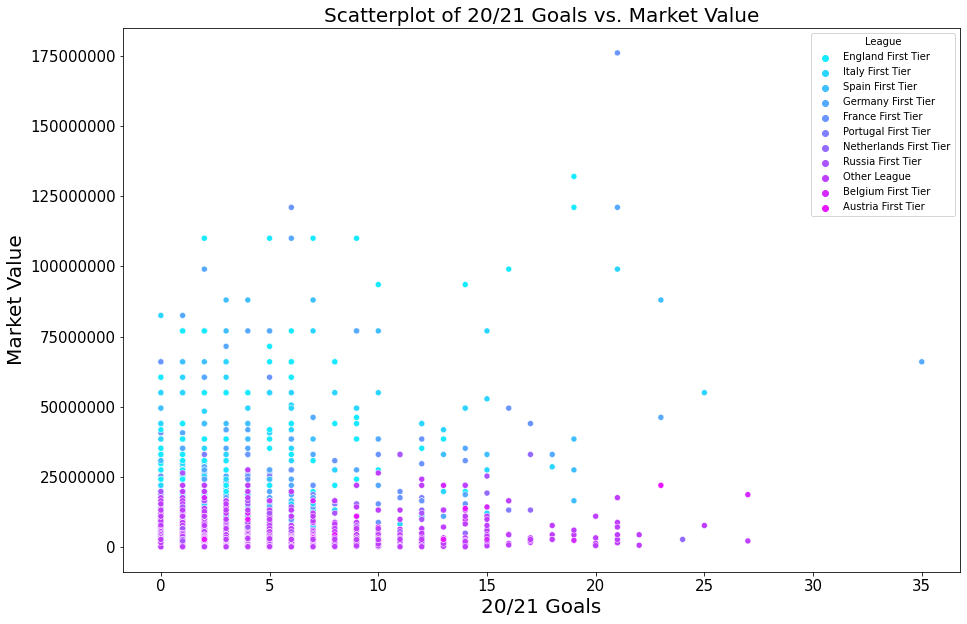

In [ ]:
# Scatterplot of 20/21 Goals vs. Market Value
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=df_unencoded, x='20/21 Goals', y='Market_Value', hue='League', palette='cool', legend=True)
ax.tick_params(labelsize=15)
ax.set_ylabel('Market Value', fontsize = 20)
ax.set_xlabel('20/21 Goals', fontsize = 20)
ax.set_title('Scatterplot of 20/21 Goals vs. Market Value', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [ ]:
# Boxplot to explore Market Value differences between leagues
xy = df_unencoded.groupby(['League']).Market_Value.mean()
xy_df_unencoded = pd.DataFrame(xy)
xy_df_unencoded = xy_df_unencoded.sort_values(by = 'Market_Value', ascending= False)
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
plt.ticklabel_format(style='plain', axis='x')
ax = sns.boxplot(y='League', x="Market_Value", data=df_unencoded, order=xy_df_unencoded.index, palette='cool')
ax.set_title('Boxplot of Market Value vs. League', fontsize=20)
ax.set_ylabel('League', fontsize = 20)
ax.set_xlabel('Market Value', fontsize = 20)

In [ ]:
# Create correlation DataFrame
copy_df = df.copy()

# Drop unecessary columns
copy_df = copy_df.drop(['ID','Name'], axis=1)

# Compute correlations
corr_df = copy_df.corr()

# View correlations with respect to Market Value
print(corr_df['Market Value'].sort_values(ascending=False))

Market Value              1.000000
England First Tier        0.371411
Contract Expiration       0.299639
19/20 Assists             0.297184
20/21 Assists             0.294986
19/20 Goals               0.284588
20/21 Goals               0.275972
19/20 Games               0.267753
Assists                   0.264306
19/20 Minutes             0.261354
20/21 Minutes             0.232497
Goals                     0.224319
20/21 Games               0.218999
Italy First Tier          0.179305
Spain First Tier          0.173487
Germany First Tier        0.163706
Games                     0.153916
19/20 Yellow              0.139305
France First Tier         0.107689
England                   0.095530
20/21 Yellow              0.093203
Yellow Cards              0.080152
France                    0.068998
Portugal                  0.049212
Spain                     0.039940
Attack                    0.038669
Height                    0.034976
Red Cards                 0.021323
Belgium             

In [ ]:
# Remove features with correlations to Market Value < 0.1 and > -0.1
copy_df = copy_df.drop(['Italy','Both','Left','Right','England','20/21 Yellow','Yellow Cards','France',
                        'Portugal','Spain','Attack','Height','Red Cards','Belgium','Uruguay','Germany',
                        '19/20 2Yellow','Brazil','20/21 Red','19/20 Red','Midfield','20/21 2Yellow',
                        'Argentina','Defense','Age'], axis=1)

# Compute correlations
corr_df = copy_df.corr()

# View correlations with respect to Market Value
print(corr_df['Market Value'].sort_values(ascending=False))

Market Value           1.000000
England First Tier     0.371411
Contract Expiration    0.299639
19/20 Assists          0.297184
20/21 Assists          0.294986
19/20 Goals            0.284588
20/21 Goals            0.275972
19/20 Games            0.267753
Assists                0.264306
Goals                  0.224319
20/21 Games            0.218999
Italy First Tier       0.179305
Spain First Tier       0.173487
Germany First Tier     0.163706
Games                  0.153916
19/20 Yellow           0.139305
France First Tier      0.107689
Other                 -0.123592
Other League          -0.354293
Name: Market Value, dtype: float64


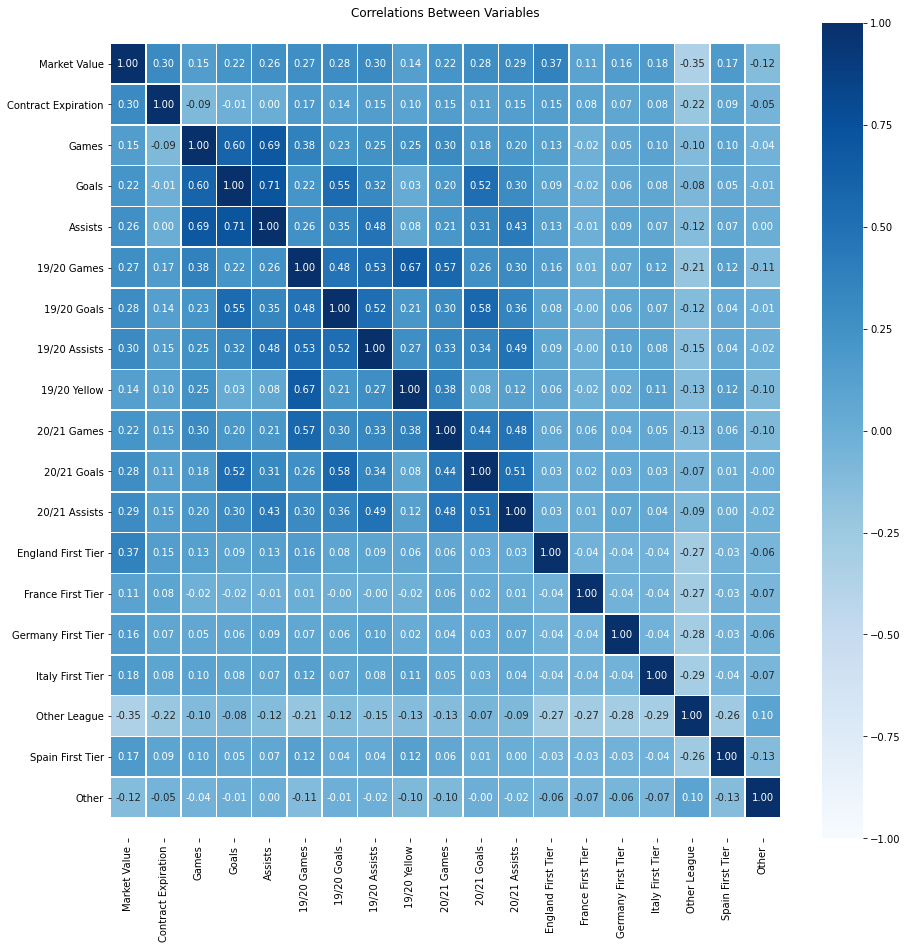

In [ ]:
# Heatmpa of correlations between variables
plt.figure(figsize = (15,15))
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap="Blues", annot=True, fmt='.2f', center=0, linewidths=.5)

# Fix for mpl bug that cuts off top/bottom of seaborn viz
bot, top = plt.ylim()
bot += 0.5
top -= 0.5
plt.ylim(bot, top)
plt.title("Correlations Between Variables")
plt.show()

In [72]:
# Drop features that cause multicollinearity issues
df = df.drop(['19/20 Minutes','20/21 Games'], axis=1)

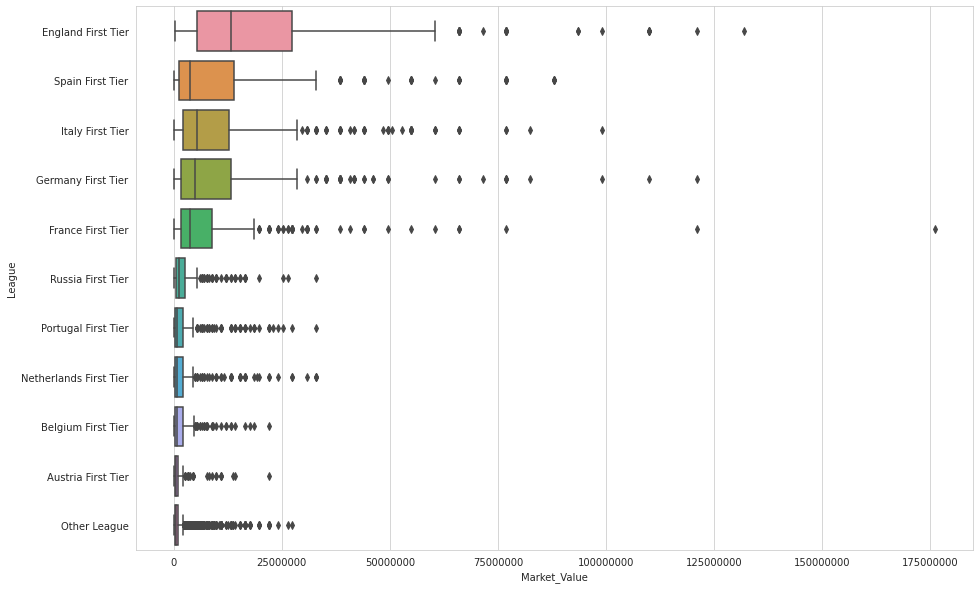

In [ ]:
# # Boxplot to explore Market Value differences between leagues
# xy = df_unencoded.groupby(['League']).Market_Value.mean()
# xy_df_unencoded = pd.DataFrame(xy)
# xy_df_unencoded = xy_df_unencoded.sort_values(by = 'Market_Value', ascending= False)
# sns.set_style('whitegrid')
# plt.figure(figsize=(15,10))
# plt.ticklabel_format(style='plain', axis='x')
# ax = sns.boxplot(y='League', x="Market_Value", data=df_unencoded, order=xy_df_unencoded.index)

# Machine Learning Models

In [73]:
# Extract features and response from dataset
features = df.loc[:,df.columns!='Market Value']
features = features.drop(['ID','Name'], axis=1)
response = df['Market Value']

In [74]:
# Split the data into training and testing sets (75/25 split)
X_train, X_test, Y_train, Y_test = train_test_split(features, response, test_size=0.25, random_state=5)


In [75]:
# Scale the data using StandardScaler (standardizes the distribution of each feature to have a mean of 0 and SD of 1)

# Create the scaler
scaler = StandardScaler()

# Fit the scaler to the training data (features only)
scaler.fit(X_train)

# Transform X_train, X_testbased on the (same) scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [76]:
# Linear Regression
MLR = LinearRegression()
MLR.fit(X_train_scaled, Y_train)
MLR_train_predicted = MLR.predict(X_train_scaled)
MLR_test_predicted = MLR.predict(X_test_scaled)

MLR_r2_train = r2_score(Y_train, MLR_train_predicted)
MLR_mse_train = mean_squared_error(Y_train, MLR_train_predicted)
MLR_rmse_train = (np.sqrt(MLR_mse_train))
MLR_mae_train = mean_absolute_error(Y_train, MLR_train_predicted)
MLR_r2_test = r2_score(Y_test, MLR_test_predicted)
MLR_mse_test = mean_squared_error(Y_test, MLR_test_predicted)
MLR_rmse_test = (np.sqrt(MLR_mse_test))
MLR_mae_test = mean_absolute_error(Y_test, MLR_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(MLR_r2_train))
print('MSE is {:,.2f}'.format(MLR_mse_train))
print('RMSE is {:,.2f}'.format(MLR_rmse_train))
print('MAE is {:,.2f}'.format(MLR_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(MLR_r2_test))
print('MSE is {:,.2f}'.format(MLR_mse_test))
print('RMSE is {:,.2f}'.format(MLR_rmse_test))
print('MAE is {:,.2f}'.format(MLR_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.41
MSE is 46,471,416,904,938.33
RMSE is 6,816,994.71
MAE is 3,370,896.32


The model performance for testing set
--------------------------------------
R2 is 0.42
MSE is 44,650,194,994,047.59
RMSE is 6,682,080.14
MAE is 3,368,888.83


In [77]:
print(MLR.coef_)

[-1.59690882e+06  1.55823450e+05  9.03095604e+05  5.95130143e+05
 -6.30510629e+05  1.54652714e+06  2.02759620e+05  7.53644366e+04
 -1.26893929e+05  7.61000988e+05  3.99306319e+05  6.31184121e+04
  1.03449839e+05 -3.96801226e+04  9.78154539e+05  7.00830435e+05
 -2.17235635e+05 -3.03402496e+04 -3.01136443e+04  4.43845652e+05
 -5.38162245e+18 -5.61090282e+18 -5.45742791e+18 -2.42852814e+17
 -4.93128593e+17 -5.19710465e+17 -2.74653625e+18 -2.69673460e+18
 -2.76698095e+18 -2.85098990e+18 -5.62027207e+18 -2.51799727e+18
  1.27108097e+18  7.71372660e+17  1.35999121e+18  1.12230077e+18
  1.29523780e+18  1.19622693e+18  1.16543185e+18  2.76375217e+18
  8.29804059e+17  1.29165072e+18  5.87221633e+17]


In [78]:
# Linear Regression with recursive feature elimination
MLR = RFECV(estimator = MLR, step = 1, cv=5, scoring='r2')
MLR.fit(X_train_scaled, Y_train)
MLR_train_predicted = MLR.predict(X_train_scaled)
MLR_test_predicted = MLR.predict(X_test_scaled)

MLR_r2_train = r2_score(Y_train, MLR_train_predicted)
MLR_mse_train = mean_squared_error(Y_train, MLR_train_predicted)
MLR_rmse_train = (np.sqrt(MLR_mse_train))
MLR_mae_train = mean_absolute_error(Y_train, MLR_train_predicted)
MLR_r2_test = r2_score(Y_test, MLR_test_predicted)
MLR_mse_test = mean_squared_error(Y_test, MLR_test_predicted)
MLR_rmse_test = (np.sqrt(MLR_mse_test))
MLR_mae_test = mean_absolute_error(Y_test, MLR_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(MLR_r2_train))
print('MSE is {:,.2f}'.format(MLR_mse_train))
print('RMSE is {:,.2f}'.format(MLR_rmse_train))
print('MAE is {:,.2f}'.format(MLR_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(MLR_r2_test))
print('MSE is {:,.2f}'.format(MLR_mse_test))
print('RMSE is {:,.2f}'.format(MLR_rmse_test))
print('MAE is {:,.2f}'.format(MLR_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.41
MSE is 46,529,455,340,630.14
RMSE is 6,821,250.28
MAE is 3,369,136.74


The model performance for testing set
--------------------------------------
R2 is 0.42
MSE is 44,695,143,760,983.47
RMSE is 6,685,442.68
MAE is 3,372,423.47


## Gradient Boosting

In [79]:
# Gradient Boosting
GBR = GradientBoostingRegressor(random_state=5)
GBR.fit(X_train, Y_train)
GBR_train_predicted = GBR.predict(X_train)
GBR_test_predicted = GBR.predict(X_test)

GBR_r2_train = r2_score(Y_train, GBR_train_predicted)
GBR_mse_train = mean_squared_error(Y_train, GBR_train_predicted)
GBR_rmse_train = (np.sqrt(GBR_mse_train))
GBR_mae_train = mean_absolute_error(Y_train, GBR_train_predicted)
GBR_r2_test = r2_score(Y_test, GBR_test_predicted)
GBR_mse_test = mean_squared_error(Y_test, GBR_test_predicted)
GBR_rmse_test = (np.sqrt(GBR_mse_test))
GBR_mae_test = mean_absolute_error(Y_test, GBR_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(GBR_r2_train))
print('MSE is {:,.2f}'.format(GBR_mse_train))
print('RMSE is {:,.2f}'.format(GBR_rmse_train))
print('MAE is {:,.2f}'.format(GBR_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(GBR_r2_test))
print('MSE is {:,.2f}'.format(GBR_mse_test))
print('RMSE is {:,.2f}'.format(GBR_rmse_test))
print('MAE is {:,.2f}'.format(GBR_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.75
MSE is 19,689,620,852,007.98
RMSE is 4,437,298.82
MAE is 1,939,326.43


The model performance for testing set
--------------------------------------
R2 is 0.60
MSE is 31,114,910,287,999.88
RMSE is 5,578,074.07
MAE is 2,191,448.72


In [80]:
# DataFrame using feature columns and feature importances
GBR_feat_import = pd.DataFrame({'Feature Name':features.columns,'Importance':GBR.feature_importances_})
GBR_feat_import = GBR_feat_import.sort_values(by='Importance', ascending=False)
GBR_feat_import

,Feature Name,Importance
30,Other League,0.308796
15,20/21 Assists,0.112781
0,Age,0.073924
14,20/21 Goals,0.073678
26,England First Tier,0.069830
19,20/21 Minutes,0.067661
2,Contract Expiration,0.058378
9,19/20 Goals,0.053096
10,19/20 Assists,0.043303
8,19/20 Games,0.035616


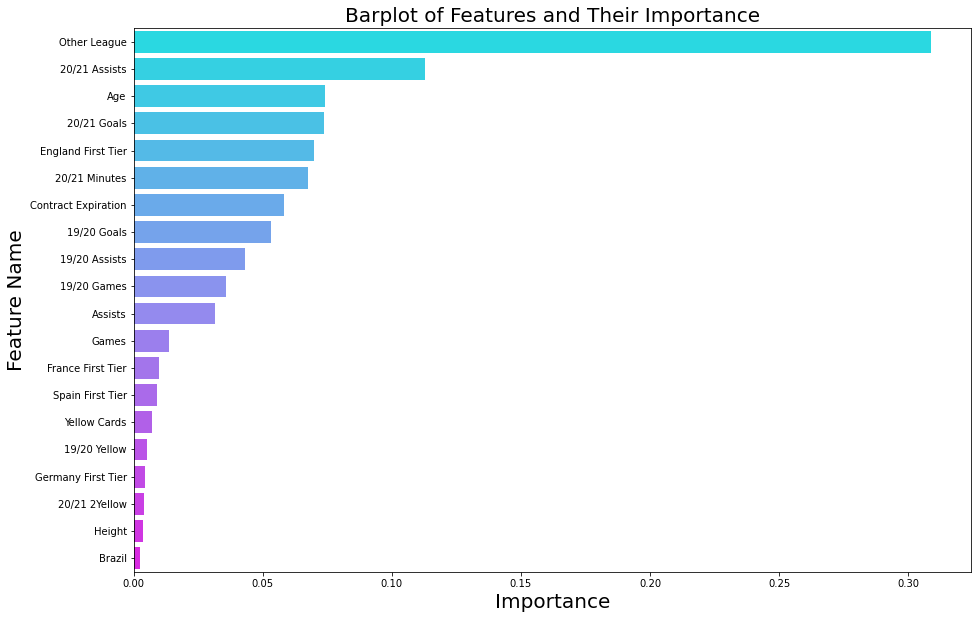

In [82]:
# Barplot of feature importances
plt.figure(figsize=(15,10))
ax = sns.barplot(x=GBR_feat_import['Importance'][:20], y=GBR_feat_import['Feature Name'][:20], palette='cool')
#plt.barh(RF_feat_import['Feature Name'], RF_feat_import['Importance'])
ax.tick_params(labelsize=10)
ax.set_ylabel('Feature Name', fontsize = 20)
ax.set_xlabel('Importance', fontsize = 20)
ax.set_title('Barplot of Features and Their Importance', fontsize=20)
plt.show()

In [101]:
# parameters to choose from in grid search CV
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [1, 0.9, 0.1],
                  'n_estimators' : [100, 500, 600],
                  'max_depth'    : [2, 3, 4, 6]
                 }

In [102]:
# this is the model used for feature selection
feature_sele = GradientBoostingRegressor(random_state=5) 

## recursive feature elimination/selection using cross validation
rfecv = RFECV(estimator=feature_sele, 
              step=1, 
              cv=5, 
              scoring = "r2")


# different model for hyper parameter tuning
gb = GradientBoostingRegressor(random_state=5)

grid_search_gb = GridSearchCV(estimator = gb, param_grid = parameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [103]:
## create a pipeline to, first, do feature selection and then tune hyper parameters using cross validation
GB_pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',grid_search_gb)])

GB_pipeline.fit(X_train, Y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 27.0min finished


Pipeline(memory=None,
         steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=GradientBoostingRegressor(alpha=0.9,
                                                           ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.1,
                                                           loss='ls',
                                                           max_depth=3,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_sample

In [104]:
grid_search_gb.best_params_

{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.9}

In [105]:
# Gradient Boosting with pipelin
GBR_train_predicted = GB_pipeline.predict(X_train)
GBR_test_predicted = GB_pipeline.predict(X_test)

GBR_r2_train = r2_score(Y_train, GBR_train_predicted)
GBR_mse_train = mean_squared_error(Y_train, GBR_train_predicted)
GBR_rmse_train = (np.sqrt(GBR_mse_train))
GBR_mae_train = mean_absolute_error(Y_train, GBR_train_predicted)
GBR_r2_test = r2_score(Y_test, GBR_test_predicted)
GBR_mse_test = mean_squared_error(Y_test, GBR_test_predicted)
GBR_rmse_test = (np.sqrt(GBR_mse_test))
GBR_mae_test = mean_absolute_error(Y_test, GBR_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(GBR_r2_train))
print('MSE is {:,.2f}'.format(GBR_mse_train))
print('RMSE is {:,.2f}'.format(GBR_rmse_train))
print('MAE is {:,.2f}'.format(GBR_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(GBR_r2_test))
print('MSE is {:,.2f}'.format(GBR_mse_test))
print('RMSE is {:,.2f}'.format(GBR_rmse_test))
print('MAE is {:,.2f}'.format(GBR_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.89
MSE is 8,411,984,095,572.23
RMSE is 2,900,342.07
MAE is 1,406,813.25


The model performance for testing set
--------------------------------------
R2 is 0.63
MSE is 28,429,820,022,249.22
RMSE is 5,331,962.12
MAE is 2,013,789.22


In [106]:
df['predicted_Market_Value'] = GB_pipeline.predict(features)

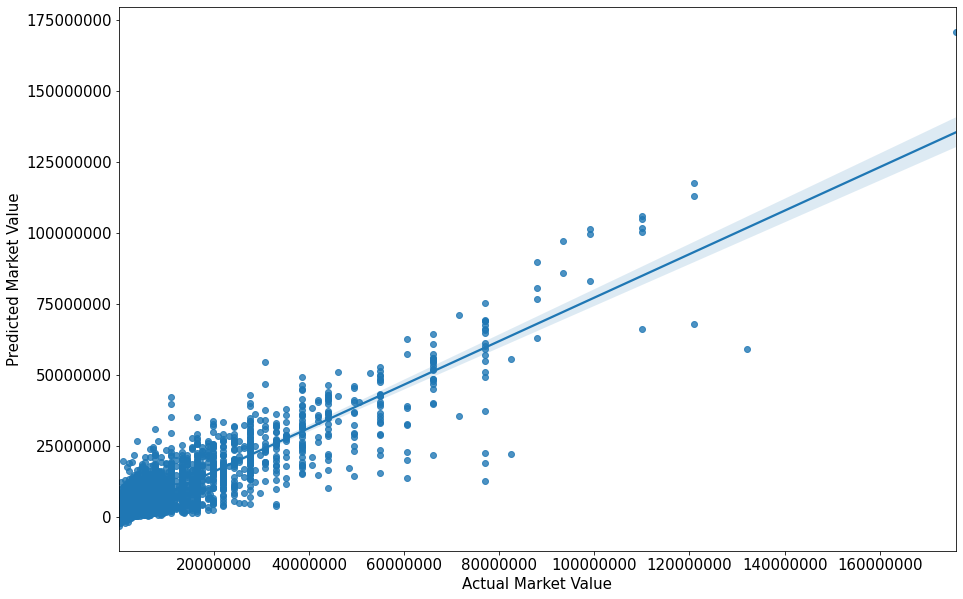

In [108]:
plt.figure(figsize=(15,10))
ax = sns.regplot(x="Market Value", y="predicted_Market_Value", data=df)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Predicted Market Value', fontsize = 15)
ax.set_xlabel('Actual Market Value', fontsize = 15)
ax.tick_params(labelsize=15)

# Decision Tree

In [83]:
# Decision Tree
DT = DecisionTreeRegressor(random_state=5, max_depth=6)
DT.fit(X_train, Y_train)
DT_train_predicted = DT.predict(X_train)
DT_test_predicted = DT.predict(X_test)

DT_r2_train = r2_score(Y_train, DT_train_predicted)
DT_mse_train = mean_squared_error(Y_train, DT_train_predicted)
DT_rmse_train = (np.sqrt(DT_mse_train))
DT_mae_train = mean_absolute_error(Y_train, DT_train_predicted)
DT_r2_test = r2_score(Y_test, DT_test_predicted)
DT_mse_test = mean_squared_error(Y_test, DT_test_predicted)
DT_rmse_test = (np.sqrt(DT_mse_test))
DT_mae_test = mean_absolute_error(Y_test, DT_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(DT_r2_train))
print('MSE is {:,.2f}'.format(DT_mse_train))
print('RMSE is {:,.2f}'.format(DT_rmse_train))
print('MAE is {:,.2f}'.format(DT_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(DT_r2_test))
print('MSE is {:,.2f}'.format(DT_mse_test))
print('RMSE is {:,.2f}'.format(DT_rmse_test))
print('MAE is {:,.2f}'.format(DT_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.64
MSE is 28,112,678,221,105.75
RMSE is 5,302,139.02
MAE is 2,199,114.16


The model performance for testing set
--------------------------------------
R2 is 0.43
MSE is 44,141,715,524,974.02
RMSE is 6,643,923.20
MAE is 2,515,877.68


In [84]:
# DataFrame using feature columns and feature importances
DT_feat_import = pd.DataFrame({'Feature Name':features.columns,'Importance':DT.feature_importances_})
DT_feat_import = DT_feat_import.sort_values(by='Importance', ascending=False)
DT_feat_import

,Feature Name,Importance
30,Other League,0.364364
15,20/21 Assists,0.199163
9,19/20 Goals,0.088470
8,19/20 Games,0.071587
5,Assists,0.070156
2,Contract Expiration,0.065390
14,20/21 Goals,0.041898
0,Age,0.026775
19,20/21 Minutes,0.025187
3,Games,0.016624


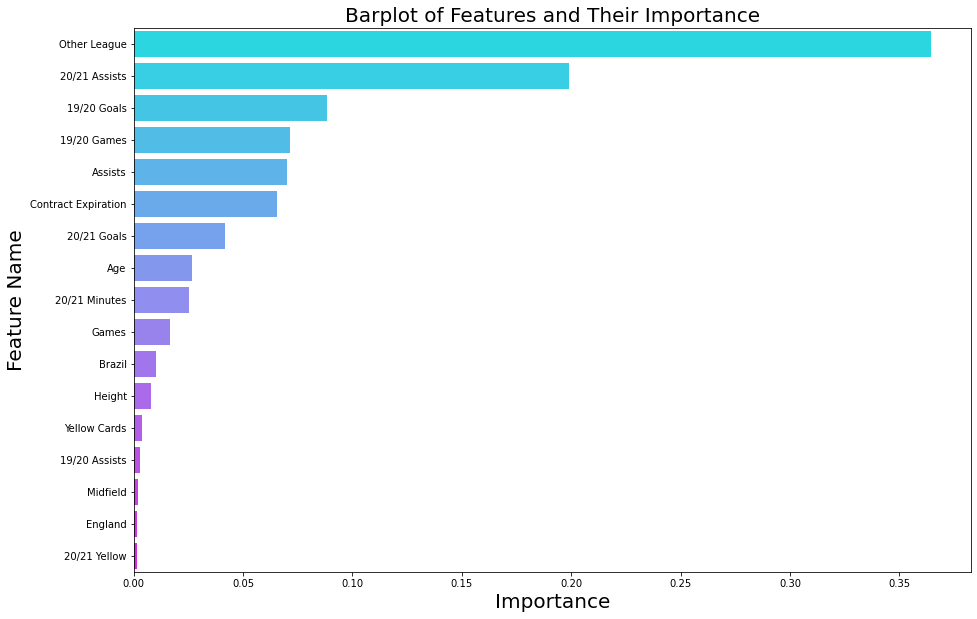

In [86]:
# Barplot of feature importances
plt.figure(figsize=(15,10))
ax = sns.barplot(x=DT_feat_import['Importance'][:17], y=DT_feat_import['Feature Name'][:17], palette='cool')
#plt.barh(RF_feat_import['Feature Name'], RF_feat_import['Importance'])
ax.tick_params(labelsize=10)
ax.set_ylabel('Feature Name', fontsize = 20)
ax.set_xlabel('Importance', fontsize = 20)
ax.set_title('Barplot of Features and Their Importance', fontsize=20)
plt.show()

In [87]:
best_features = DT_feat_import[:20]['Feature Name'].values.tolist()

In [88]:
# recreate dataset with the top 20 features (as determined by our decision tree)

features2 = df.loc[:,df.columns!='Market Value']
features2 = features2.drop(['ID','Name'], axis=1)
for feature in features2.columns:
    if feature not in best_features:
        features2 = features2.drop([feature], axis=1)
    
response2 = df['Market Value']

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(features2, response2, test_size=0.25, random_state =5)


In [89]:
# Decision Tree
DT = DecisionTreeRegressor(random_state=5, max_depth=5)
DT.fit(X_train2, Y_train2)
DT_train_predicted = DT.predict(X_train2)
DT_test_predicted = DT.predict(X_test2)

DT_r2_train = r2_score(Y_train2, DT_train_predicted)
DT_mse_train = mean_squared_error(Y_train2, DT_train_predicted)
DT_rmse_train = (np.sqrt(DT_mse_train))
DT_mae_train = mean_absolute_error(Y_train2, DT_train_predicted)
DT_r2_test = r2_score(Y_test2, DT_test_predicted)
DT_mse_test = mean_squared_error(Y_test2, DT_test_predicted)
DT_rmse_test = (np.sqrt(DT_mse_test))
DT_mae_test = mean_absolute_error(Y_test2, DT_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(DT_r2_train))
print('MSE is {:,.2f}'.format(DT_mse_train))
print('RMSE is {:,.2f}'.format(DT_rmse_train))
print('MAE is {:,.2f}'.format(DT_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(DT_r2_test))
print('MSE is {:,.2f}'.format(DT_mse_test))
print('RMSE is {:,.2f}'.format(DT_rmse_test))
print('MAE is {:,.2f}'.format(DT_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.57
MSE is 33,963,710,103,180.77
RMSE is 5,827,839.23
MAE is 2,389,936.20


The model performance for testing set
--------------------------------------
R2 is 0.46
MSE is 41,487,297,996,629.31
RMSE is 6,441,063.42
MAE is 2,541,780.73


In [110]:
df['predicted_Market_Value'] = DT.predict(features2)

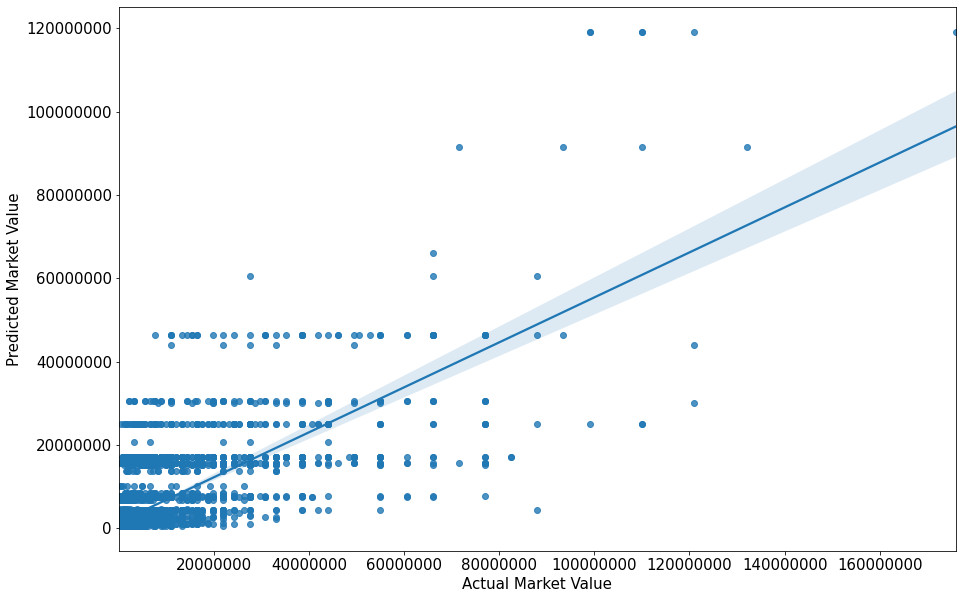

In [111]:
plt.figure(figsize=(15,10))
ax = sns.regplot(x="Market Value", y="predicted_Market_Value", data=df)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Predicted Market Value', fontsize = 15)
ax.set_xlabel('Actual Market Value', fontsize = 15)
ax.tick_params(labelsize=15)

# Random Forest Regressor

In [90]:
# Random Forest
RF = RandomForestRegressor(random_state=5)
RF.fit(X_train, Y_train)
RF_train_predicted = RF.predict(X_train)
RF_test_predicted = RF.predict(X_test)

RF_r2_train = r2_score(Y_train, RF_train_predicted)
RF_mse_train = mean_squared_error(Y_train, RF_train_predicted)
RF_rmse_train = (np.sqrt(RF_mse_train))
RF_mae_train = mean_absolute_error(Y_train, RF_train_predicted)
RF_r2_test = r2_score(Y_test, RF_test_predicted)
RF_mse_test = mean_squared_error(Y_test, RF_test_predicted)
RF_rmse_test = (np.sqrt(RF_mse_test))
RF_mae_test = mean_absolute_error(Y_test, RF_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(RF_r2_train))
print('MSE is {:,.2f}'.format(RF_mse_train))
print('RMSE is {:,.2f}'.format(RF_rmse_train))
print('MAE is {:,.2f}'.format(RF_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(RF_r2_test))
print('MSE is {:,.2f}'.format(RF_mse_test))
print('RMSE is {:,.2f}'.format(RF_rmse_test))
print('MAE is {:,.2f}'.format(RF_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.94
MSE is 5,015,300,336,838.73
RMSE is 2,239,486.62
MAE is 817,791.49


The model performance for testing set
--------------------------------------
R2 is 0.59
MSE is 31,270,847,407,358.79
RMSE is 5,592,034.28
MAE is 2,172,284.54


In [91]:
# DataFrame using feature columns and feature importances
RF_feat_import = pd.DataFrame({'Feature Name':features.columns,'Importance':RF.feature_importances_})
RF_feat_import = RF_feat_import.sort_values(by='Importance', ascending=False)
RF_feat_import

,Feature Name,Importance
30,Other League,0.235187
15,20/21 Assists,0.106268
19,20/21 Minutes,0.072474
14,20/21 Goals,0.062590
8,19/20 Games,0.060657
0,Age,0.059149
2,Contract Expiration,0.054007
9,19/20 Goals,0.052258
5,Assists,0.036197
10,19/20 Assists,0.036007


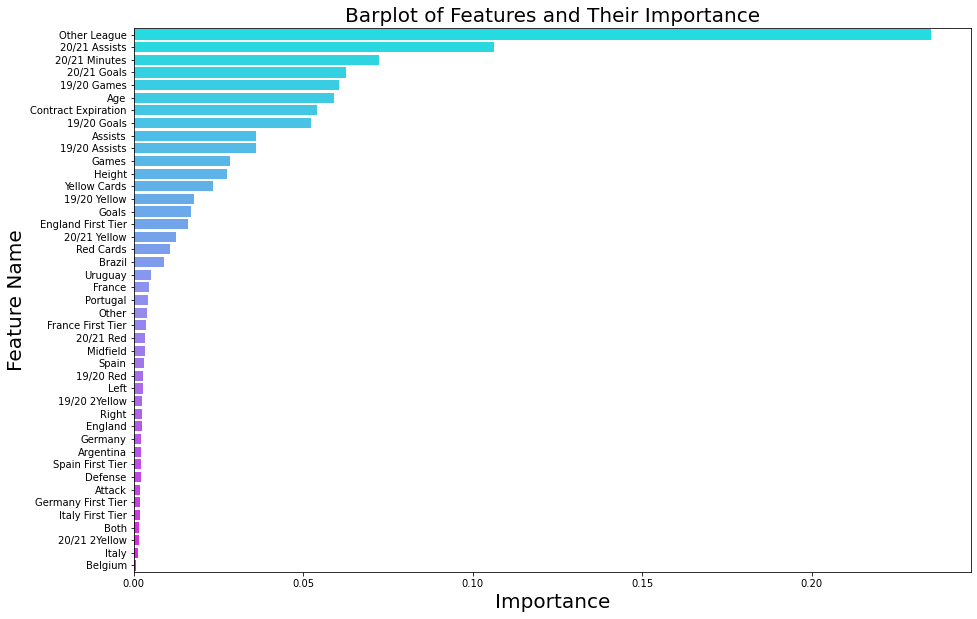

In [92]:
# Barplot of feature importances
plt.figure(figsize=(15,10))
ax = sns.barplot(x=RF_feat_import['Importance'], y=RF_feat_import['Feature Name'], palette='cool')
#plt.barh(RF_feat_import['Feature Name'], RF_feat_import['Importance'])
ax.tick_params(labelsize=10)
ax.set_ylabel('Feature Name', fontsize = 20)
ax.set_xlabel('Importance', fontsize = 20)
ax.set_title('Barplot of Features and Their Importance', fontsize=20)
plt.show()

In [114]:
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': [10, 50, 100, 200, 300],  # Number of trees in random forest
               'max_features': max_features,
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None], # Maximum number of levels in tree
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [121]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring="r2")
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 40.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_
## using this random search to get a grid for best parameters to use in non randomized grid search

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [116]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80, 90],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [3, 5, 6],
    'n_estimators': [200, 300, 500]
}

In [117]:
#this is the model used for feature selection
featr_sele = RandomForestRegressor(random_state=5) 

# recursive feature selection using cross validation (5 folds)
rfecv = RFECV(estimator=featr_sele, 
              step=1, 
              cv=5, 
              scoring = "r2")


# different model for hyper paramter tuning
rf = RandomForestRegressor(random_state=5)

# using grid search cross validation to hyper parameter tuning (3 folds)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [118]:
# creates a pipeline that seqeuentially applies feature selection and hyper parameter tuning transformations
RF_pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',grid_search)])

RF_pipeline.fit(X_train, Y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 35.2min finished


Pipeline(memory=None,
         steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=RandomForestRegressor(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
         

In [24]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 200}

In [25]:
# Random Forest using pipeline
RF_train_predicted = RF_pipeline.predict(X_train)
RF_test_predicted = RF_pipeline.predict(X_test)

RF_r2_train = r2_score(Y_train, RF_train_predicted)
RF_mse_train = mean_squared_error(Y_train, RF_train_predicted)
RF_rmse_train = (np.sqrt(RF_mse_train))
RF_mae_train = mean_absolute_error(Y_train, RF_train_predicted)
RF_r2_test = r2_score(Y_test, RF_test_predicted)
RF_mse_test = mean_squared_error(Y_test, RF_test_predicted)
RF_rmse_test = (np.sqrt(RF_mse_test))
RF_mae_test = mean_absolute_error(Y_test, RF_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(RF_r2_train))
print('MSE is {:,.2f}'.format(RF_mse_train))
print('RMSE is {:,.2f}'.format(RF_rmse_train))
print('MAE is {:,.2f}'.format(RF_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(RF_r2_test))
print('MSE is {:,.2f}'.format(RF_mse_test))
print('RMSE is {:,.2f}'.format(RF_rmse_test))
print('MAE is {:,.2f}'.format(RF_mae_test))

The model performance for training set
--------------------------------------
R2 is 0.86
MSE is 11,164,065,081,644.62
RMSE is 3,341,266.99
MAE is 1,169,260.36


The model performance for testing set
--------------------------------------
R2 is 0.58
MSE is 34,227,619,640,487.57
RMSE is 5,850,437.56
MAE is 2,217,476.42


In [119]:
df['predicted_Market_Value'] = RF_pipeline.predict(features)


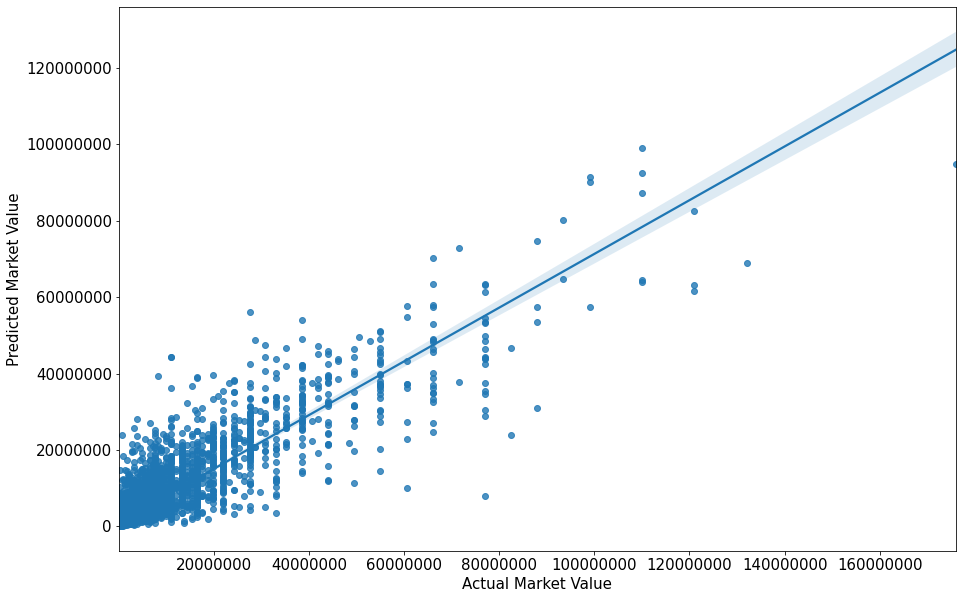

In [120]:
plt.figure(figsize=(15,10))
ax = sns.regplot(x="Market Value", y="predicted_Market_Value", data=df)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Predicted Market Value', fontsize = 15)
ax.set_xlabel('Actual Market Value', fontsize = 15)
ax.tick_params(labelsize=15)

# Adaboost Regressor

In [93]:
ada = AdaBoostRegressor(random_state=5, learning_rate=0.1, n_estimators=75)
    
ada.fit(X_train, Y_train)
ada_train_predicted = ada.predict(X_train)
ada_test_predicted = ada.predict(X_test)

ada_r2_train = ada.score(X_train, Y_train)
ada_mse_train = mean_squared_error(Y_train, ada_train_predicted)
ada_rmse_train = (np.sqrt(ada_mse_train))
ada_mae_train = mean_absolute_error(Y_train, ada_train_predicted)
ada_r2_test =  ada.score(X_test, Y_test)
ada_mse_test = mean_squared_error(Y_test, ada_test_predicted)
ada_rmse_test = (np.sqrt(ada_mse_test))
ada_mae_test = mean_absolute_error(Y_test, ada_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(ada_r2_train))
print('MSE is {:,.2f}'.format(ada_mse_train))
print('RMSE is {:,.2f}'.format(RF_rmse_train))
print('MAE is {:,.2f}'.format(ada_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(ada_r2_test))
print('MSE is {:,.2f}'.format(ada_mse_test))
print('RMSE is {:,.2f}'.format(ada_rmse_test))
print('MAE is {:,.2f}'.format(ada_mae_test))
    
    


The model performance for training set
--------------------------------------
R2 is 0.39
MSE is 47,798,420,882,931.57
RMSE is 2,239,486.62
MAE is 3,390,652.59


The model performance for testing set
--------------------------------------
R2 is 0.32
MSE is 52,349,776,663,040.40
RMSE is 7,235,314.55
MAE is 3,502,731.69


In [94]:
# DataFrame using feature columns and feature importances
ada_feat_import = pd.DataFrame({'Feature Name':features.columns,'Importance':ada.feature_importances_})
ada_feat_import = ada_feat_import.sort_values(by='Importance', ascending=False)
ada_feat_import

,Feature Name,Importance
30,Other League,0.435602
14,20/21 Goals,0.111730
9,19/20 Goals,0.096653
15,20/21 Assists,0.074925
5,Assists,0.073123
0,Age,0.060186
10,19/20 Assists,0.052738
8,19/20 Games,0.025863
1,Height,0.019369
2,Contract Expiration,0.017377


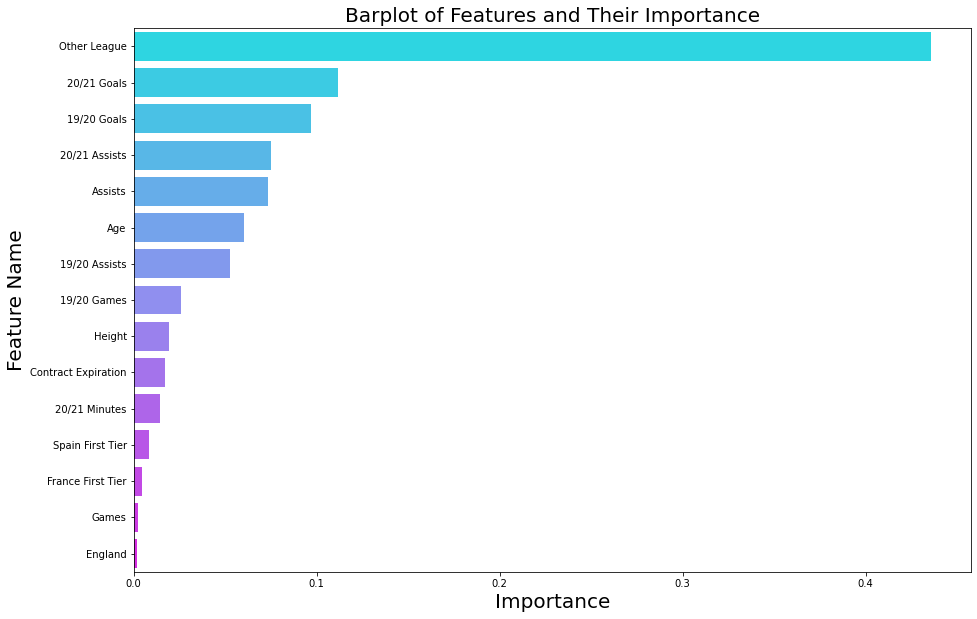

In [95]:
# Barplot of feature importances
plt.figure(figsize=(15,10))
ax = sns.barplot(x=ada_feat_import['Importance'][:15], y=ada_feat_import['Feature Name'][:15], palette='cool')
ax.tick_params(labelsize=10)
ax.set_ylabel('Feature Name', fontsize = 20)
ax.set_xlabel('Importance', fontsize = 20)
ax.set_title('Barplot of Features and Their Importance', fontsize=20)
plt.show()

In [96]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'n_estimators' : [10, 25, 50, 75, 100, 200, 400],
                 }

In [97]:
#this is the model used for feature selection
featr_sele = AdaBoostRegressor(random_state=5, n_estimators=3) 

## recursive feature elimination
rfecv = RFECV(estimator=featr_sele, 
              step=1, 
              cv=5, 
              scoring = "r2")


# different model for cv
ada = AdaBoostRegressor(random_state=5, n_estimators=3) 

grid_search_ada = GridSearchCV(estimator = ada, param_grid = parameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [98]:
## create a pipeline to, first, do feature selection and then tune hyper parameters using cross validation
ada_pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',grid_search_ada)])

ada_pipeline.fit(X_train, Y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  2.4min finished


Pipeline(memory=None,
         steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=AdaBoostRegressor(base_estimator=None,
                                                   learning_rate=1.0,
                                                   loss='linear',
                                                   n_estimators=3,
                                                   random_state=5),
                       min_features_to_select=1, n_jobs=None, scoring='r2',
                       step=1, verbose=0)),
                ('clf_cv',
                 GridSearchCV(cv=3, error_score=nan,
                              estimator=AdaBoostRegressor(base_estimator=None,
                                                          learning_rate=1.0,
                                                          loss='linear',
                                                          n_estimators=3,
                                                          random_state

In [99]:
grid_search_ada.best_params_

{'learning_rate': 0.02, 'n_estimators': 75}

In [100]:
# Adaboost using pipeline
ada_train_predicted = ada_pipeline.predict(X_train)
ada_test_predicted = ada_pipeline.predict(X_test)

ada_r2_train = ada_pipeline.score(X_train, Y_train)
ada_mse_train = mean_squared_error(Y_train, ada_train_predicted)
ada_rmse_train = (np.sqrt(ada_mse_train))
ada_mae_train = mean_absolute_error(Y_train, ada_train_predicted)
ada_r2_test =  ada_pipeline.score(X_test, Y_test)
ada_mse_test = mean_squared_error(Y_test, ada_test_predicted)
ada_rmse_test = (np.sqrt(ada_mse_test))
ada_mae_test = mean_absolute_error(Y_test, ada_test_predicted)

print("The model performance for training set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(ada_r2_train))
print('MSE is {:,.2f}'.format(ada_mse_train))
print('RMSE is {:,.2f}'.format(RF_rmse_train))
print('MAE is {:,.2f}'.format(ada_mae_train))
print("\n")

print("The model performance for testing set")
print("--------------------------------------")
print('R2 is {:,.2f}'.format(ada_r2_test))
print('MSE is {:,.2f}'.format(ada_mse_test))
print('RMSE is {:,.2f}'.format(ada_rmse_test))
print('MAE is {:,.2f}'.format(ada_mae_test))
    

The model performance for training set
--------------------------------------
R2 is 0.49
MSE is 40,515,888,500,930.09
RMSE is 2,239,486.62
MAE is 2,759,678.44


The model performance for testing set
--------------------------------------
R2 is 0.44
MSE is 43,499,516,094,629.23
RMSE is 6,595,416.29
MAE is 2,859,616.98


In [112]:
df['predicted_Market_Value'] = ada_pipeline.predict(features)


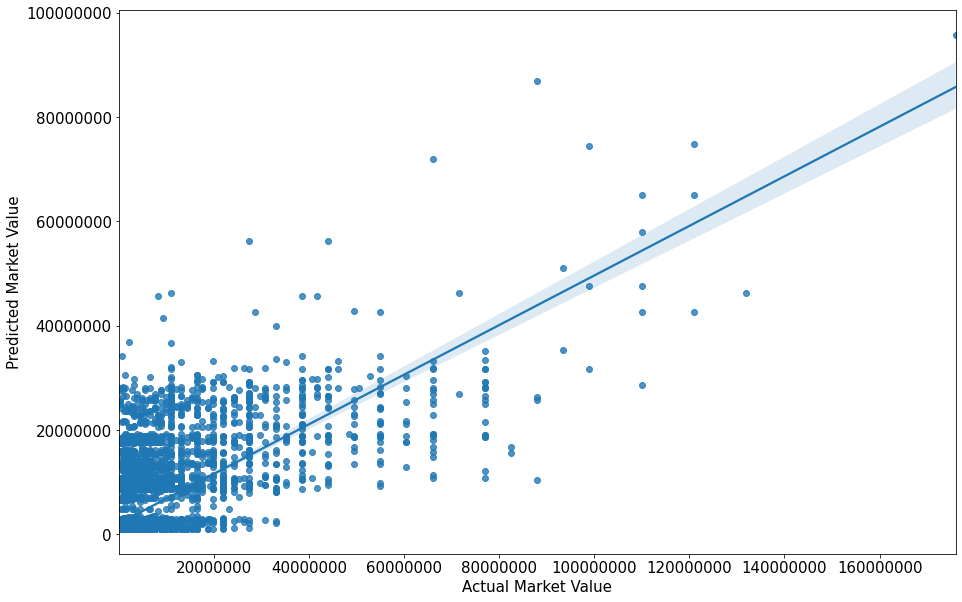

In [113]:
plt.figure(figsize=(15,10))
ax = sns.regplot(x="Market Value", y="predicted_Market_Value", data=df)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Predicted Market Value', fontsize = 15)
ax.set_xlabel('Actual Market Value', fontsize = 15)
ax.tick_params(labelsize=15)